# A toy example of Real NVP (using the ML class)

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets

from matplotlib import pyplot as plt

batch_size = 128
epochs = 5000
test_size = 500
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
from pixyz.distributions import Normal, InverseTransformedDistribution
from pixyz.flows import AffineCoupling, FlowList, BatchNorm1d
from pixyz.models import ML

In [3]:
def plot_samples(points, noise):
    X_LIMS = (-1.5, 2.5)
    Y_LIMS = (-2.5, 2.5)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(121)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25, c="b")
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)
    ax.set_xlabel("p(x)")
    
    X_LIMS = (-3, 3)
    Y_LIMS = (-3, 3)
    
    ax = fig.add_subplot(122)
    ax.scatter(noise[:, 0], noise[:, 1], alpha=0.7, s=25, c="r")
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)
    ax.set_xlabel("p(z)")

    plt.show()

In [4]:
x_dim = 2
z_dim = x_dim

In [5]:
# prior
loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim, name="prior")

In [6]:
class ScaleTranslateNet(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(in_features, hidden_features),
                                    nn.ReLU(),
                                    nn.Linear(hidden_features, hidden_features),
                                    nn.ReLU())
        self.log_s = nn.Linear(hidden_features, in_features)
        self.t = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        hidden = self.layers(x)
        log_s = torch.tanh(self.log_s(hidden))
        t = self.t(hidden)
        return log_s, t

In [7]:
# flow
flow_list = []
for i in range(5):
        scale_translate_net = nn.Sequential(nn.Linear(x_dim, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, x_dim * 2))
        flow_list.append(AffineCoupling(in_features=2,
                                        scale_translate_net=ScaleTranslateNet(x_dim, 256),
                                        inverse_mask=(i%2!=0)))
        flow_list.append(BatchNorm1d(2))

f = FlowList(flow_list)

In [8]:
# inverse transformed distribution (z -> f^-1 -> x)
p = InverseTransformedDistribution(prior=prior, flow=f, var=["x"])
p.to(device)

InverseTransformedDistribution(
  (prior): Normal()
  (flow): FlowList(
    (0): AffineCoupling(
      in_features=2, mask_type=channel_wise, inverse_mask=False
      (scale_translate_net): ScaleTranslateNet(
        (layers): Sequential(
          (0): Linear(in_features=2, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
        )
        (log_s): Linear(in_features=256, out_features=2, bias=True)
        (t): Linear(in_features=256, out_features=2, bias=True)
      )
    )
    (1): BatchNorm1d()
    (2): AffineCoupling(
      in_features=2, mask_type=channel_wise, inverse_mask=True
      (scale_translate_net): ScaleTranslateNet(
        (layers): Sequential(
          (0): Linear(in_features=2, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
        )
        (log_s): Linear(in_features=256, out_featu

In [9]:
model = ML(p, optimizer=optim.Adam, optimizer_params={"lr":1e-2})
print(model)

Distributions (for training): 
  p(x) 
Loss function: 
  mean(-(log p(x))) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.01
      weight_decay: 0
  )


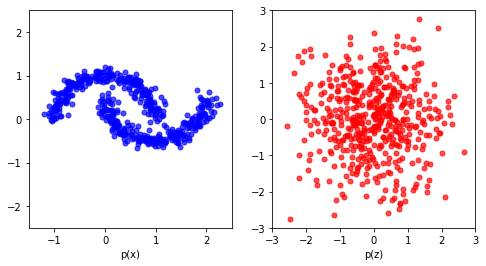

In [10]:
# plot training set
from sklearn import datasets
x = datasets.make_moons(n_samples=test_size, noise=0.1)[0].astype("float32")
noise = prior.sample(batch_size=test_size)["z"].data.cpu()
plot_samples(x, noise)

Epoch: 0 Test loss: 1.9938


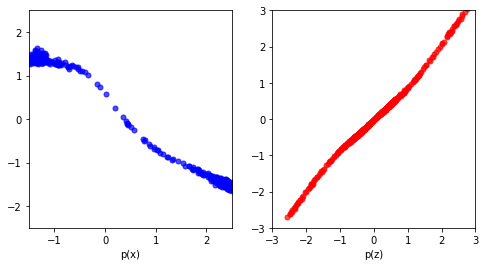

Epoch: 500 Test loss: 1.1914


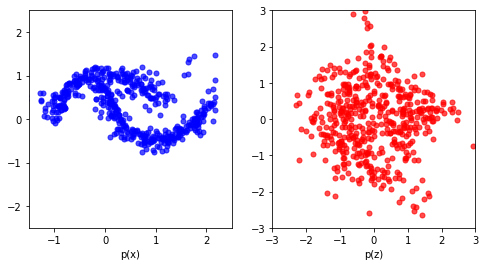

Epoch: 1000 Test loss: 1.4475


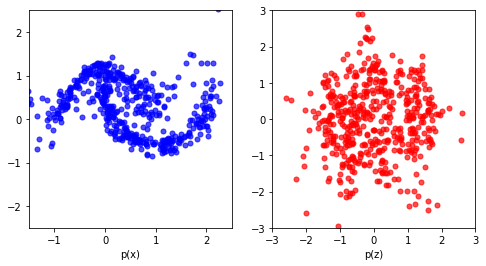

Epoch: 1500 Test loss: 1.1877


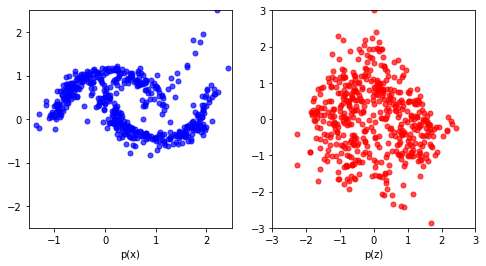

Epoch: 2000 Test loss: 1.1796


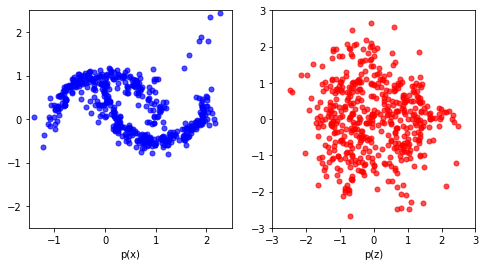

Epoch: 2500 Test loss: 1.3091


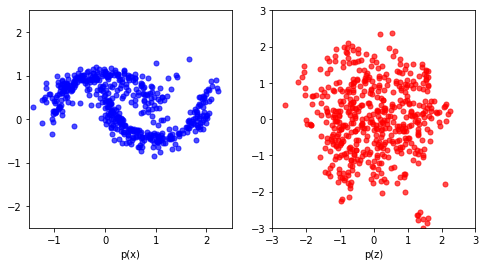

Epoch: 3000 Test loss: 1.2354


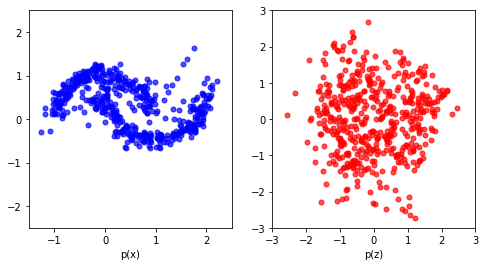

Epoch: 3500 Test loss: 1.2908


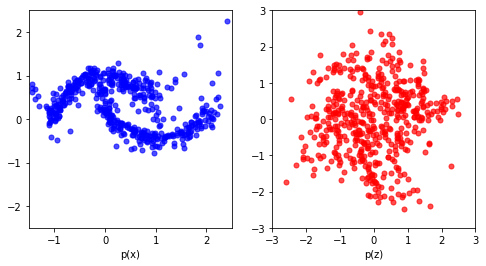

Epoch: 4000 Test loss: 1.1303


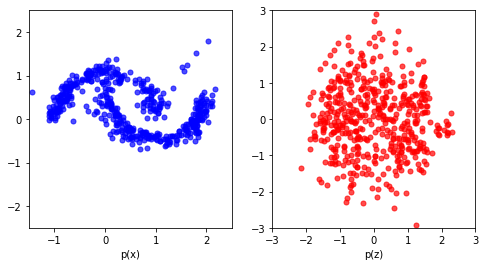

Epoch: 4500 Test loss: 1.1028


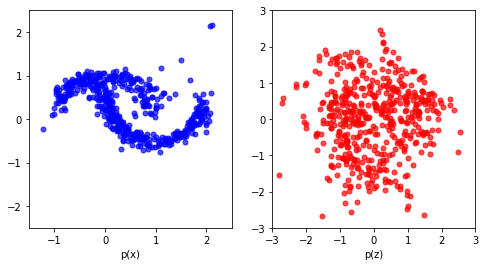

In [11]:
for epoch in range(epochs):
    x = datasets.make_moons(n_samples=batch_size, noise=0.1)[0].astype("float32")
    x = torch.tensor(x).to(device)
    loss = model.train({"x": x})

    if epoch % 500 == 0:
        print('Epoch: {} Test loss: {:.4f}'.format(epoch, loss))
        
        # samples
        samples = p.sample(batch_size=test_size)["x"].data.cpu()
        
        # inference
        _x = datasets.make_moons(n_samples=test_size, noise=0.1)[0].astype("float32")
        _x = torch.tensor(_x).to(device)
        noise = p.inference({"x": _x})["z"].data.cpu()
        
        plot_samples(samples, noise)

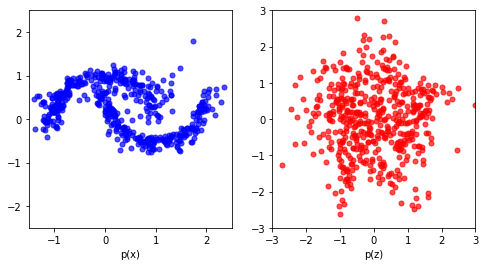

In [12]:
samples = p.sample(batch_size=test_size)["x"].data.cpu()

# inference
_x = datasets.make_moons(n_samples=test_size, noise=0.1)[0].astype("float32")
_x = torch.tensor(_x).to(device)
noise = p.inference({"x": _x})["z"].data.cpu()

plot_samples(samples, noise)